# Импорт библиотек

In [1062]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.liner_model import LinearRegression

ModuleNotFoundError: No module named 'sklearn'

# Определение функций и классов

## Определение функций генерации данных и их визуализации

In [1010]:
def true_fun(x, a=np.pi, b=0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai * np.power(x, i + 1) for i, ai in enumerate(a)], axis=0)

    return f(x + b)

#---------------------------------
def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

#---------------------------------
def dataset(a, b, f=None,  N=250, x_max=1, noise_power=0, random_x=True,  seed=42):
    np.random.seed(seed)

    if random_x:
        x = np.sort(np.random.rand(N)) * x_max
    else:
        x = np.linspace(0, x_max, N)

    y_true = np.array([])

    for f_ in np.append([], f):
        y_true = np.append(y_true, true_fun(x, a, b, f_))

    y_true = y_true.reshape(-1, N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

#---------------------------------
def vis_data(y, y_true,x, title):
    fig = plt.figure(figsize=(10, 7))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные", s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true, label="Реальные Данные", s=81, c='g', alpha=0.8)
    plt.grid()
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.legend(fontsize=12)
    plt.title(title, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);
    plt.tight_layout()

## Определение функции разделения набора данных на обучающий и тестовый

In [1011]:
def train_test_split(x, y, train_size=None, test_size=None, random_state=42, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)

    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size <= 1):  train_size = 1 - test_size
        else: train_size = size - test_size

        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size <= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val, y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 

    return x_train, y_train.squeeze(), x_val, y_val.squeeze()

## Определение функций визуализации обучающих и тестовых данных 

In [1012]:
def plot_model_weights(x_train, y_train, x_test, x, y, weights):
    plt.plot(x_train[:,0], predict(x_train, weights,), '.', label='Предсказание на x_train', markersize = 15)
    plt.plot(x_test[:,0], predict(x_test, weights,), 'o', label='Предсказание на x_test', markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.', label="Тренировочные данные", linewidth=2, c='r')
    plt.plot(x[:,0], y, '--', label="Истинные Значения", linewidth=4, c='g')
    plt.legend(fontsize=16); plt.grid()
    plt.xlabel('x',fontsize=16)
    plt.ylabel('y',fontsize=16);
    plt.xticks(FontSize=12)
    plt.yticks(FontSize=12);

def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train), '.', label='Предсказание на x_train', markersize=15)
    plt.plot(x_test[:,0], model.predict(x_test), 'o', label='Предсказание на x_test', markersize=15, alpha=0.8)
    plt.plot(x_train[:,0], y_train, '.', label="Тренировочные данные", linewidth=2, c='r')
    plt.plot(x[:,0], y, '--', label="Истинные Значения", linewidth=4, c='g')
    plt.legend(fontsize=16); plt.grid()
    plt.xlabel('x',fontsize=16)
    plt.ylabel('y',fontsize=16);
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12);

## Определение функции визуализации весов признаков

In [1013]:
def vis_weigths(weights):
    numbers = np.arange(0, len(weights))
    tick_labels = ['w' + str(num) for num in numbers]
    cc = [''] * len(numbers)

    for n, val in enumerate(weights):
        if val < 0:
            cc[n] = 'red'
        elif val >= 0:
            cc[n] = 'blue'

    plt.bar(x=numbers, height=weights, color=cc)
    plt.xticks(np.arange(0, len(weights)), tick_labels)

## Описания функции создания полинома из входных данных

In [1014]:
def to_polynom(x, order=1, add_bias=False):
    order_range = range(0 if add_bias else 1, order+1, 1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])

    for i in order_range:
        out = np.append(out, np.power(x, i))

    return out.reshape(-1, x.size).T

## Определение класса линейной регрессии

In [1015]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self, yhat, y):
        return np.square(yhat - y).sum() / y.size
    
    #---------------------------------
    def grad_step(self, yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size) / np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1 - np.sum(np.square(y - yhat)) / np.sum(np.square(y - np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias, self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size // self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X, y)): 
                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]

    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0, y.size, self.batch_size):
            idx_batch = idxs[i_batch:i_batch + self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize=(12, 6), title=''):
        plt.figure(figsize=figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize=24)
        plt.ylabel('Функция Потерь', fontsize=24)
        plt.title(title, fontsize=24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

## Определение класса L2 регуляризации

In [1060]:
class LassoRegression(LinearRegression):
    def __init__(self,
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)

        self.l1_penalty = l1_penalty

    #---------------------------------
    def loss(self,yhat, y):
        l1_term = self.l1_penalty * np.sum(np.abs(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term

    #---------------------------------
    def update(self):
        return self.weights - self.lr * (self.grad + np.sign(self.weights) * self.l1_penalty)


## Определение класса L2 регуляризации

In [1061]:
class RidgeRegression(LinearRegression):
    def __init__(self,
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100,
                 weights = None,
                 bias    = None,
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):

        super().__init__(learning_rate = learning_rate,
                         epochs = epochs,
                         weights = weights,
                         bias    = bias,
                         batch_size   = batch_size,
                         n_batches    = n_batches,
                         random_state = random_state)

        self.l2_penalty = l2_penalty

    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term

    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty * np.mean(self.weights[1:])
        return self.weights - self.lr * (self.grad + l2_term)

## Определение класса эластичной регуляризации

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty * np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty / 2) * np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty * np.sum(self.weights[1:])
        return self.weights - self.lr * (self.grad +  np.sign(self.weights) * self.l1_penalty + l2_term)

# Синтетические данные

## Набор данных №1 (линейная зависимость)

### Генерация и визуализация данных

In [1018]:
noise_power = 0.1

y1, y1_true, x1 = dataset(
    a=2,
    b=-1,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

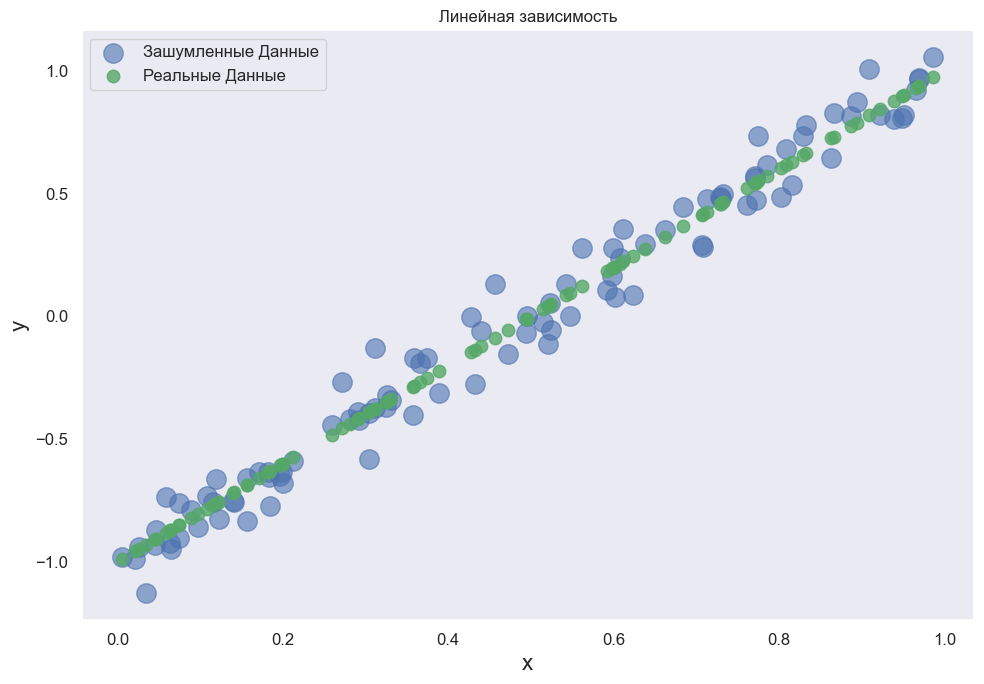

In [1019]:
vis_data(y1, y1_true, x1, 'Линейная зависимость')

### Линейная регрессия

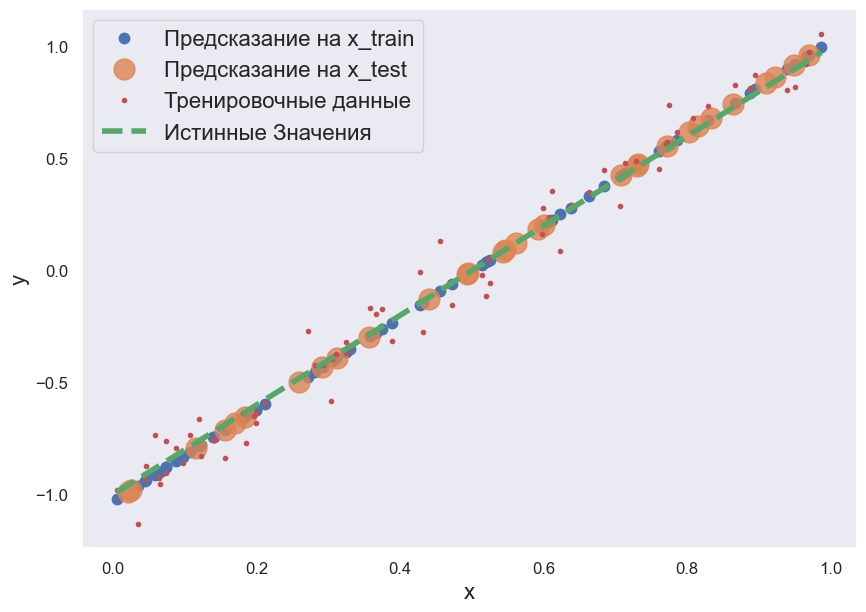

In [1020]:
linear_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x1_train, y1_train, x1_test, y1_test = train_test_split(x1, y1, test_size=0.3)

linear_regression.fit(x1_train, y1_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x1_train, y1_train, x1_test, x1, y1_true, linear_regression)

### Полиноминальная регрессия

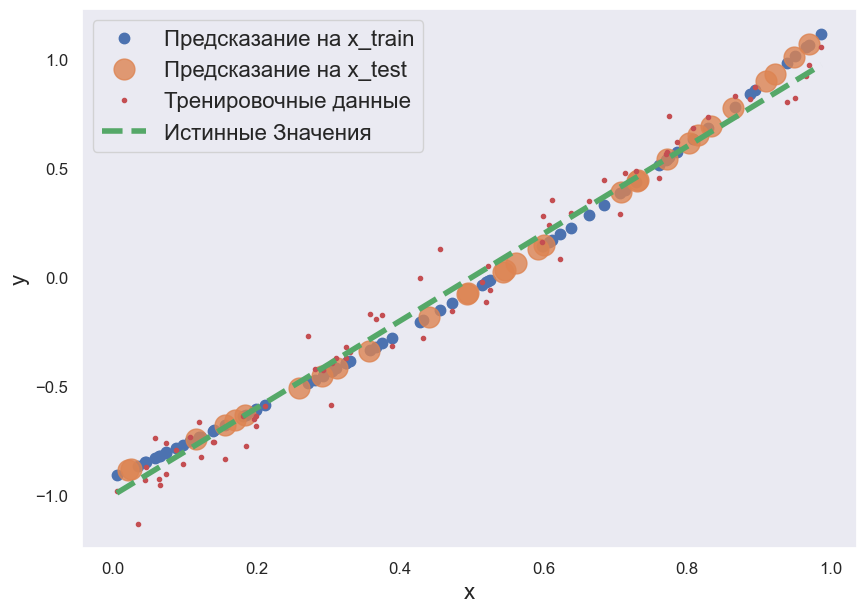

In [1021]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x1_pol = to_polynom(x1, order=3)
x1_pol_train, y1_pol_train, x1_pol_test, y1_pol_test = train_test_split(x1_pol, y1, test_size=0.3)

polynomial_regression.fit(x1_pol_train, y1_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x1_pol_train, y1_pol_train, x1_pol_test, x1_pol, y1_true, polynomial_regression)

### L1 регуляризация

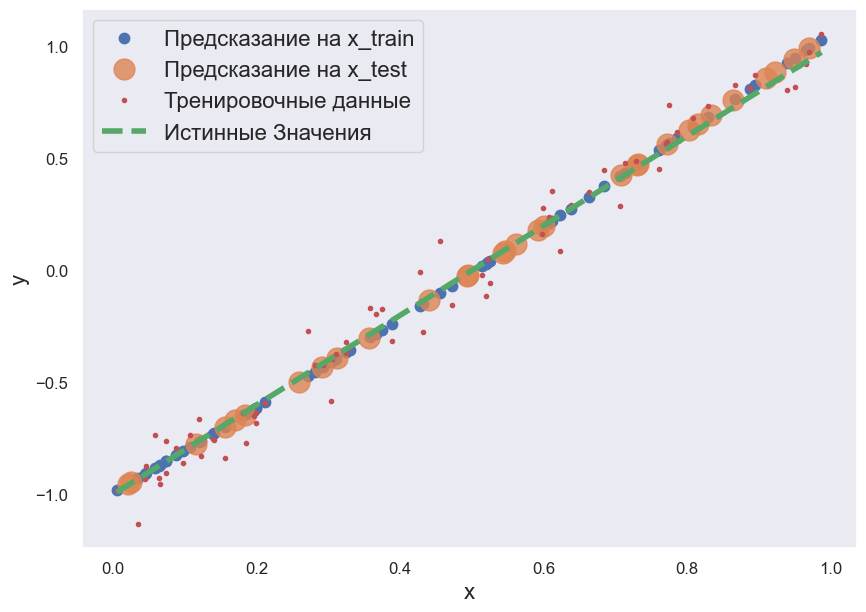

In [1022]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x1_lasso = to_polynom(x1, order=3)
x1_lasso_train, y1_lasso_train, x1_lasso_test, y1_lasso_test = train_test_split(x1_lasso, y1, test_size=0.3)

lasso_regression.fit(x1_lasso_train, y1_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x1_lasso_train, y1_lasso_train, x1_lasso_test, x1_lasso, y1_true, lasso_regression)

### L2 регуляризация

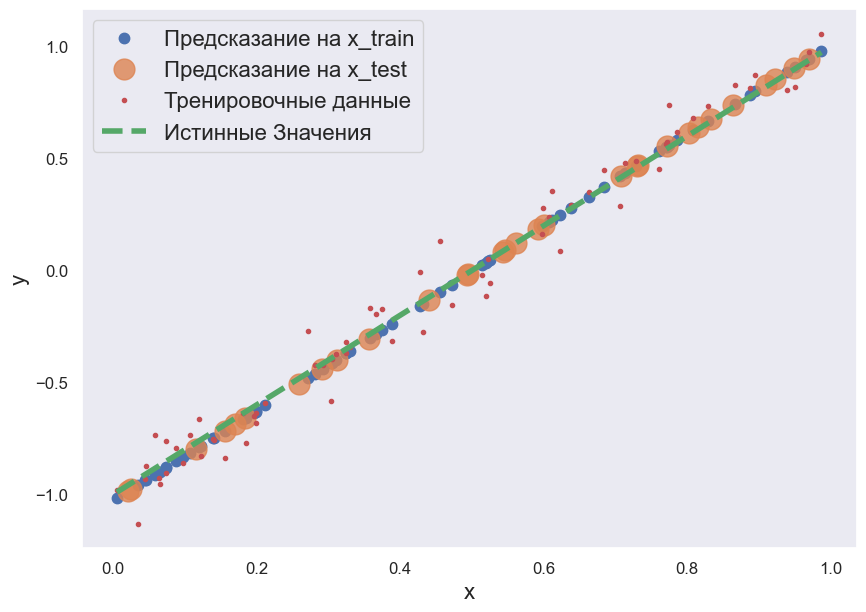

In [1023]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x1_ridge = to_polynom(x1, order=3)
x1_ridge_train, y1_ridge_train, x1_ridge_test, y1_ridge_test = train_test_split(x1_ridge, y1, test_size=0.3)

ridge_regression.fit(x1_ridge_train, y1_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x1_ridge_train, y1_ridge_train, x1_ridge_test, x1_ridge, y1_true, ridge_regression)

## Набор данных №2 (полиноминальная зависимость)

### Генерация и визуализация данных

In [1024]:
noise_power = 0.1

y2, y2_true, x2 = dataset(
    a=[-2, 3, -1],
    b=2,
    f=None,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

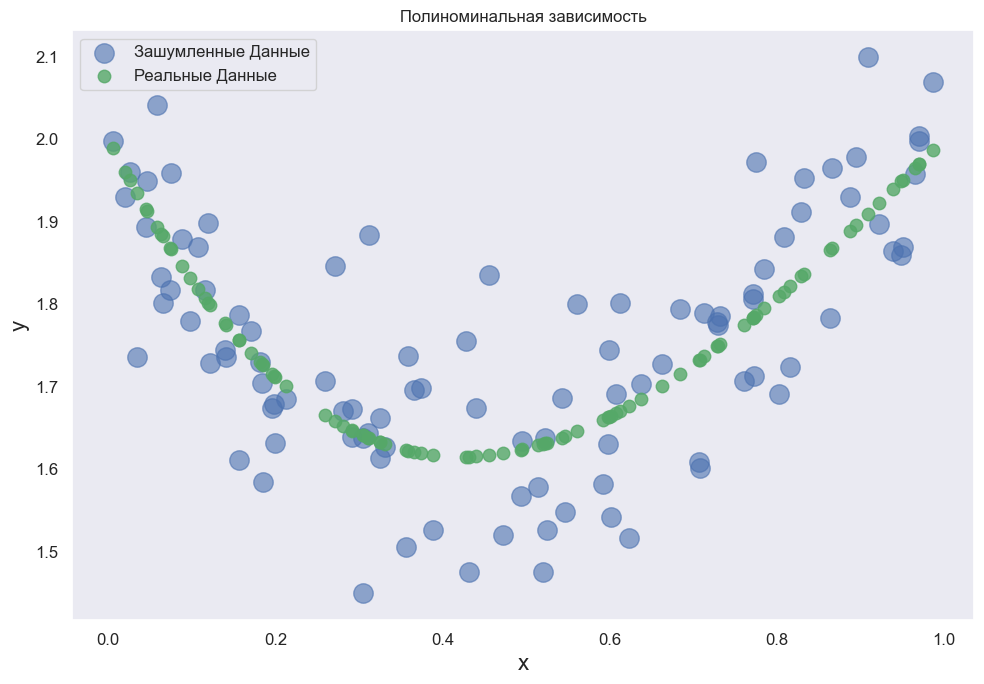

In [1025]:
vis_data(y2, y2_true, x2, 'Полиноминальная зависимость')

### Линейная регрессия

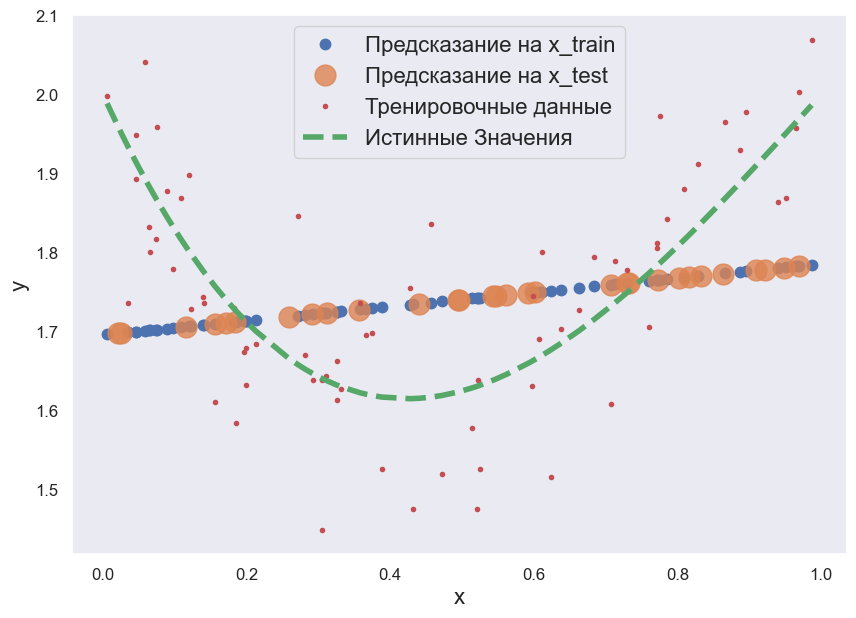

In [1026]:
x2_train, y2_train, x2_test, y2_test = train_test_split(x2, y2, test_size=0.3)

linear_regression.fit(x2_train, y2_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x2_train, y2_train, x2_test, x2, y2_true, linear_regression)

### Полиноминальная регрессия

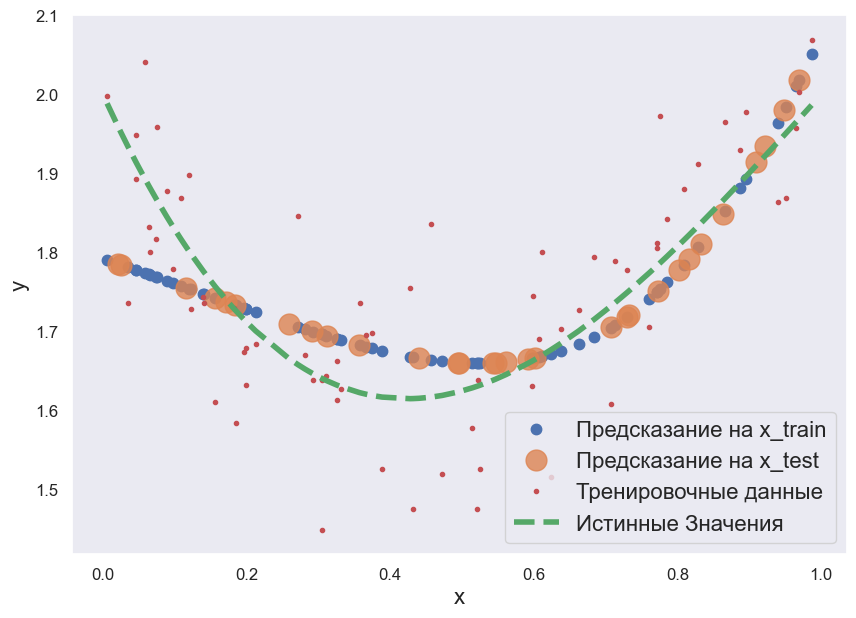

In [1027]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x2_pol = to_polynom(x2, order=10)
x2_pol_train, y2_pol_train, x2_pol_test, y2_pol_test = train_test_split(x2_pol, y2, test_size=0.3)

polynomial_regression.fit(x2_pol_train, y2_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x2_pol_train, y2_pol_train, x2_pol_test, x2_pol, y2_true, polynomial_regression)

### L1 регуляризация

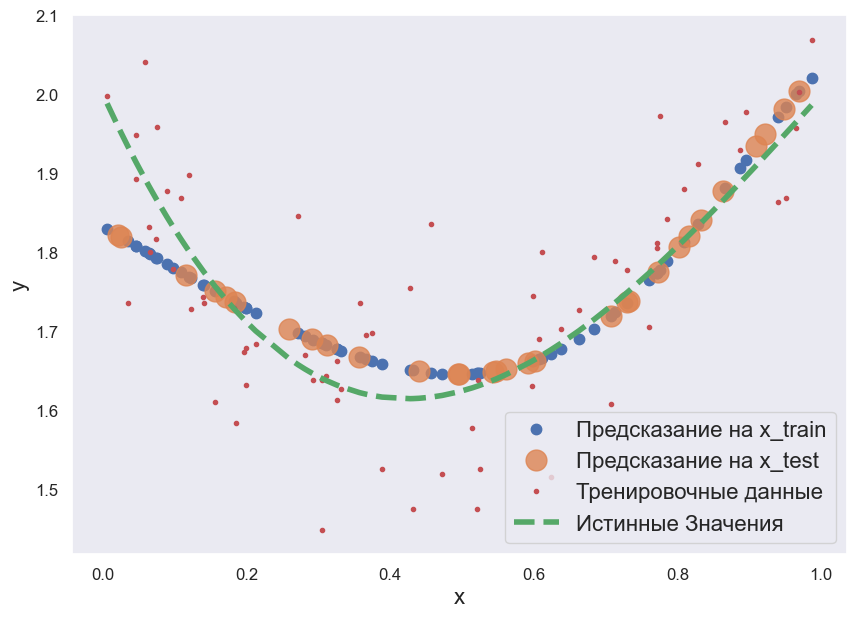

In [1028]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x2_lasso = to_polynom(x2, order=10)
x2_lasso_train, y2_lasso_train, x2_lasso_test, y2_lasso_test = train_test_split(x2_lasso, y2, test_size=0.3)

lasso_regression.fit(x2_lasso_train, y2_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x2_lasso_train, y2_lasso_train, x2_lasso_test, x2_lasso, y2_true, lasso_regression)

### L2 регуляризация

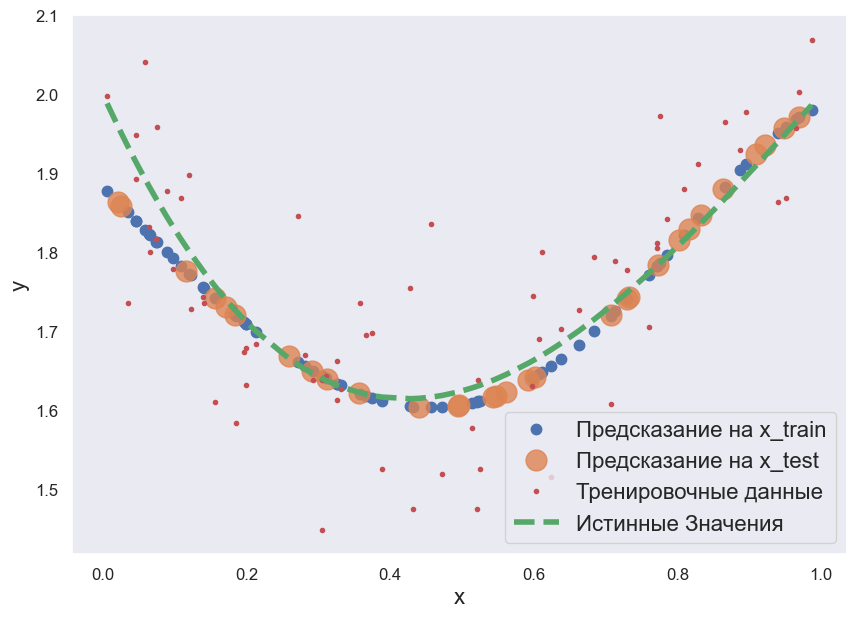

In [1029]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x2_ridge = to_polynom(x2, order=7)
x2_ridge_train, y2_ridge_train, x2_ridge_test, y2_ridge_test = train_test_split(x2_ridge, y2, test_size=0.3)

ridge_regression.fit(x2_ridge_train, y2_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x2_ridge_train, y2_ridge_train, x2_ridge_test, x2_ridge, y2_true, ridge_regression)

## Набор данных №3 (гармоническая зависимость)

### Генерация и визуализация данных

In [1030]:
noise_power = 0.1

y3, y3_true, x3 = dataset(
    a=-4,
    b=-2,
    f=np.cos,
    N=100,
    x_max=np.pi/2,
    noise_power=noise_power,
    seed=42
)

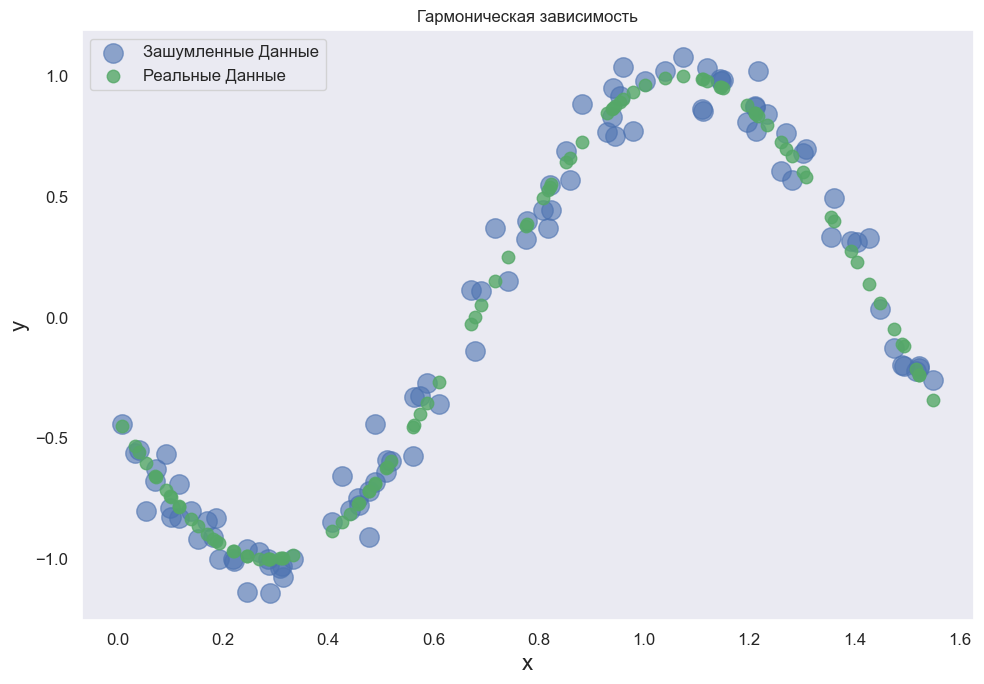

In [1031]:
vis_data(y3, y3_true, x3, 'Гармоническая зависимость')

### Линейная регрессия

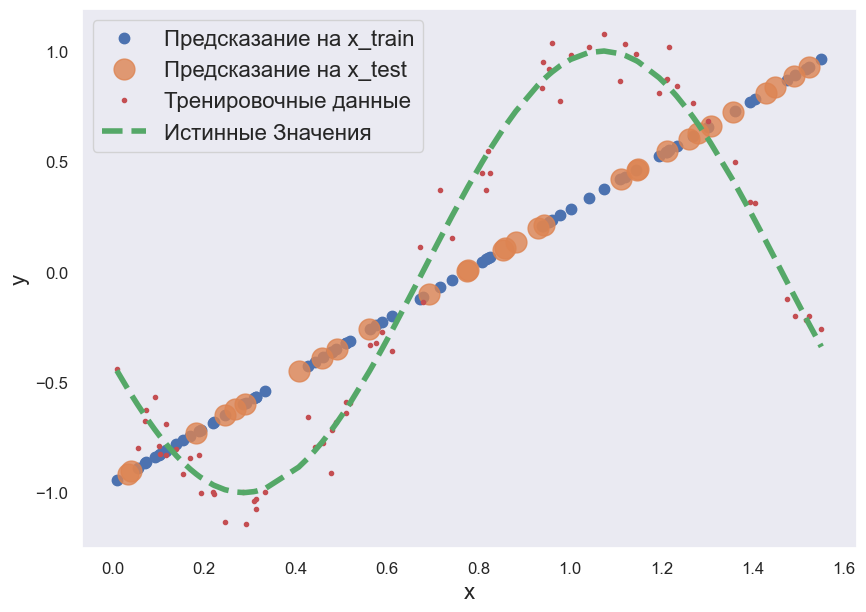

In [1032]:
x3_train, y3_train, x3_test, y3_test = train_test_split(x3, y3, test_size=0.3)

linear_regression.fit(x3_train, y3_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x3_train, y3_train, x3_test, x3, y3_true, linear_regression)

### Полиноминальная регрессия

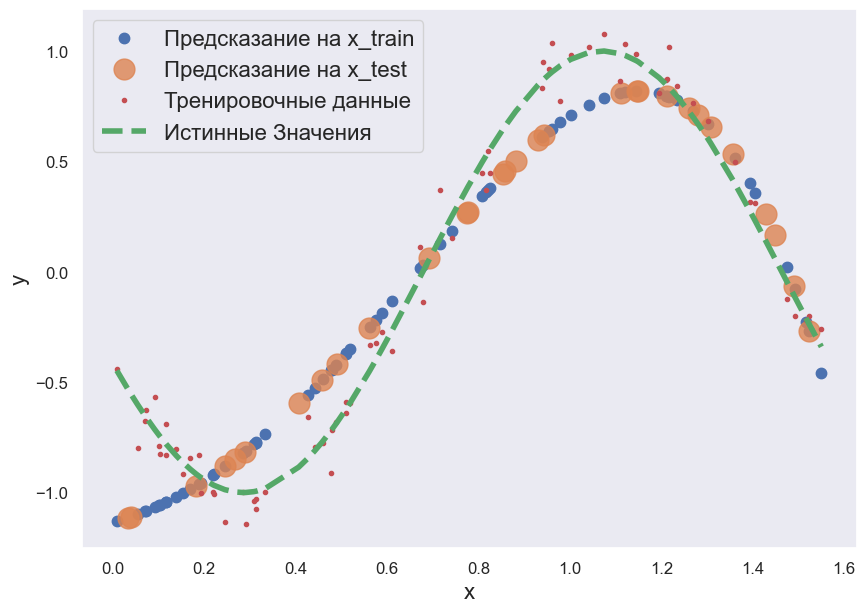

In [1033]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x3_pol = to_polynom(x3, order=4)
x3_pol_train, y3_pol_train, x3_pol_test, y3_pol_test = train_test_split(x3_pol, y3, test_size=0.3)

polynomial_regression.fit(x3_pol_train, y3_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x3_pol_train, y3_pol_train, x3_pol_test, x3_pol, y3_true, polynomial_regression)

### L1 регуляризация

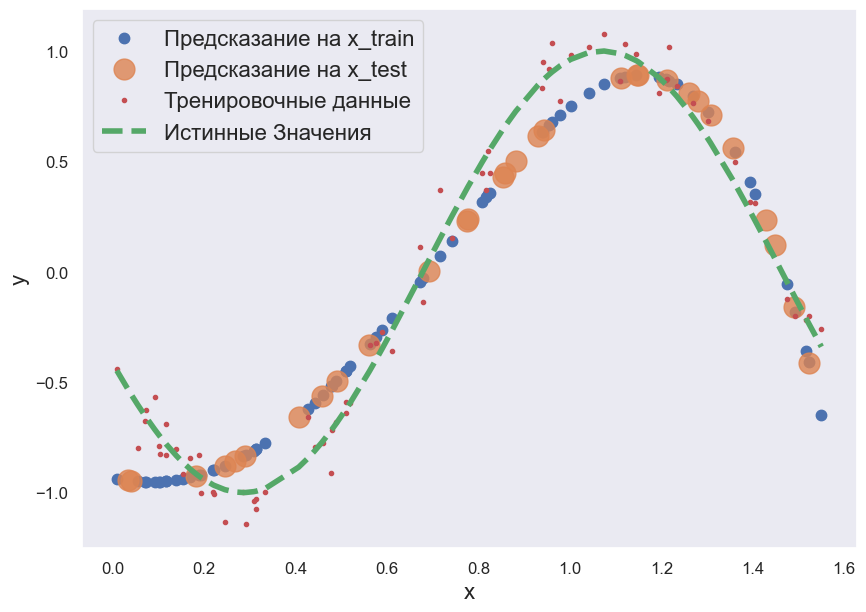

In [1034]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x3_lasso = to_polynom(x3, order=4)
x3_lasso_train, y3_lasso_train, x3_lasso_test, y3_lasso_test = train_test_split(x3_lasso, y3, test_size=0.3)

lasso_regression.fit(x3_lasso_train, y3_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x3_lasso_train, y3_lasso_train, x3_lasso_test, x3_lasso, y3_true, lasso_regression)

### L2 регуляризация

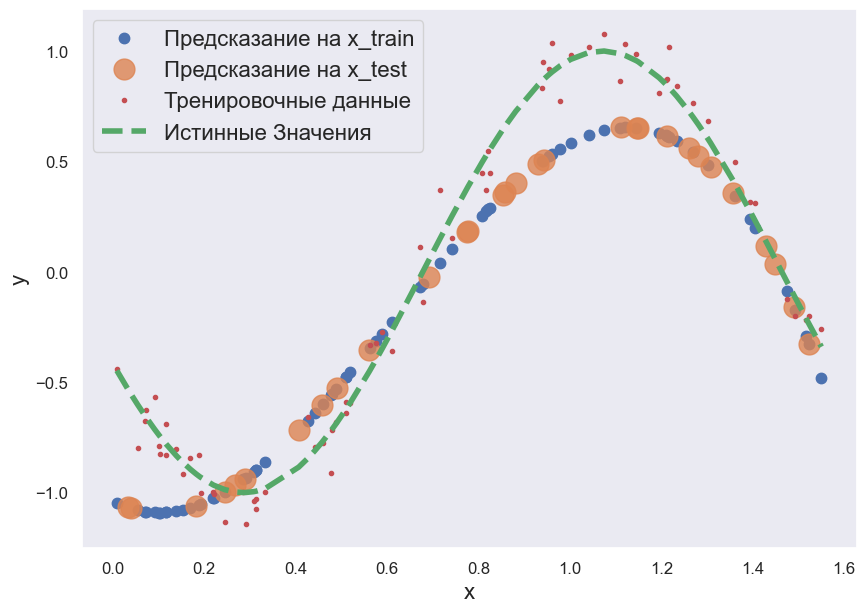

In [1035]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x3_ridge = to_polynom(x3, order=3)
x3_ridge_train, y3_ridge_train, x3_ridge_test, y3_ridge_test = train_test_split(x3_ridge, y3, test_size=0.3)

ridge_regression.fit(x3_ridge_train, y3_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x3_ridge_train, y3_ridge_train, x3_ridge_test, x3_ridge, y3_true, ridge_regression)

## Набор данных №4 (экспоненциальная зависимость)

### Генерация и визуализация данных

In [1036]:
noise_power = 0.1

y4, y4_true, x4 = dataset(
    a=1,
    b=-2,
    f=np.exp,
    N=100,
    x_max=1,
    noise_power=noise_power,
    seed=42
)

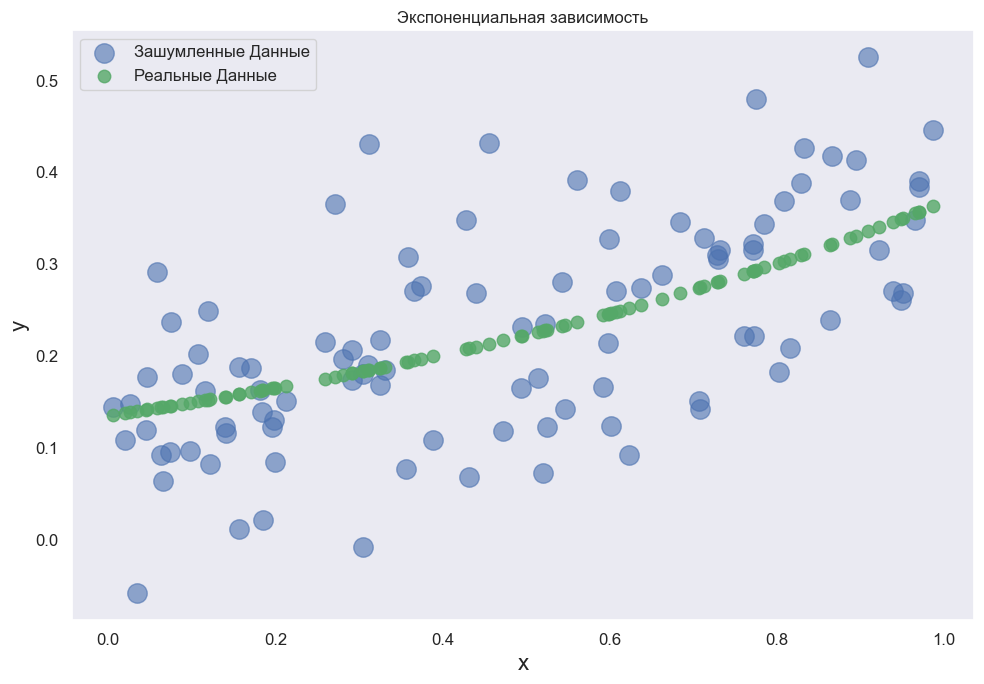

In [1037]:
vis_data(y4, y4_true, x4, 'Экспоненциальная зависимость')

### Линейная регрессия

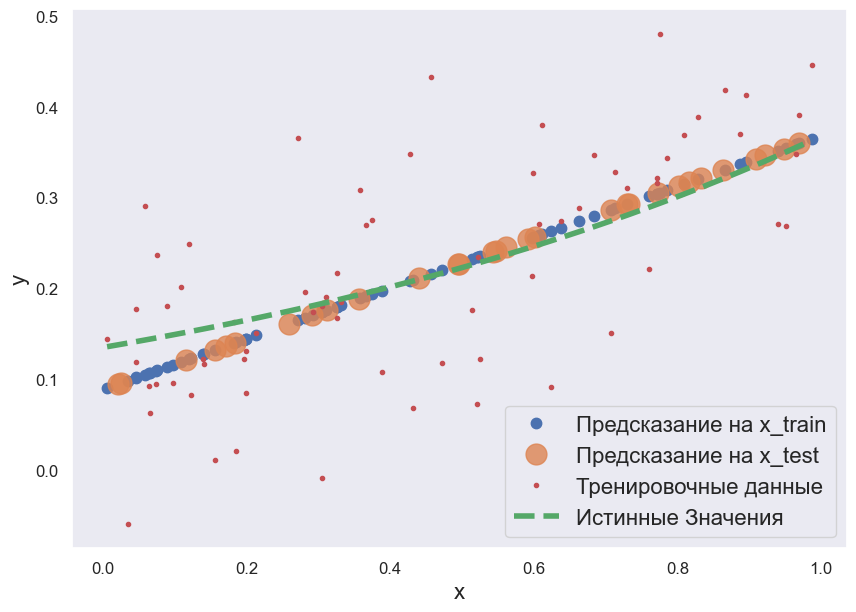

In [1038]:
x4_train, y4_train, x4_test, y4_test = train_test_split(x4, y4, test_size=0.3,)

linear_regression.fit(x4_train, y4_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x4_train, y4_train, x4_test, x4, y4_true, linear_regression)

### Полиноминальная регрессия

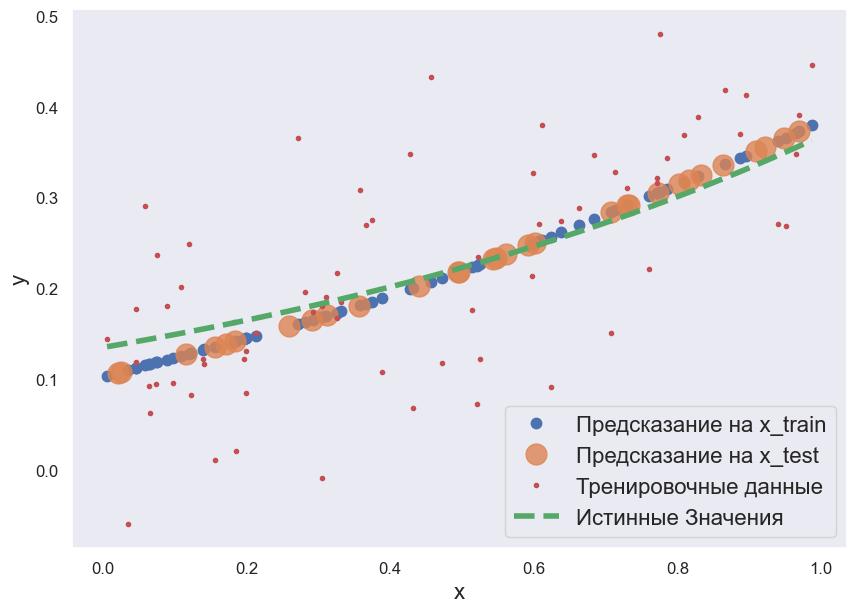

In [1039]:
polynomial_regression = LinearRegression(
    learning_rate=0.1,
    epochs=100,
    batch_size=10,
    n_batches=None
)

x4_pol = to_polynom(x4, order=7)
x4_pol_train, y4_pol_train, x4_pol_test, y4_pol_test = train_test_split(x4_pol, y4, test_size=0.3)

polynomial_regression.fit(x4_pol_train, y4_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x4_pol_train, y4_pol_train, x4_pol_test, x4_pol, y4_true, polynomial_regression)

### L1 регуляризация

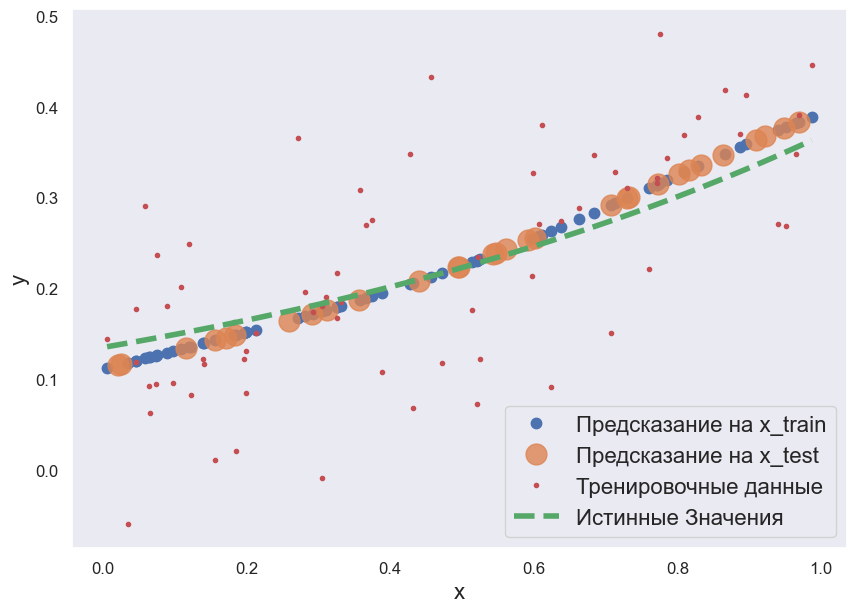

In [1040]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty=0.001
)

x4_lasso = to_polynom(x4, order=7)
x4_lasso_train, y4_lasso_train, x4_lasso_test, y4_lasso_test = train_test_split(x4_lasso, y4, test_size=0.3)

lasso_regression.fit(x4_lasso_train, y4_lasso_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x4_lasso_train, y4_lasso_train, x4_lasso_test, x4_lasso, y4_true, lasso_regression)

### L2 регуляризация

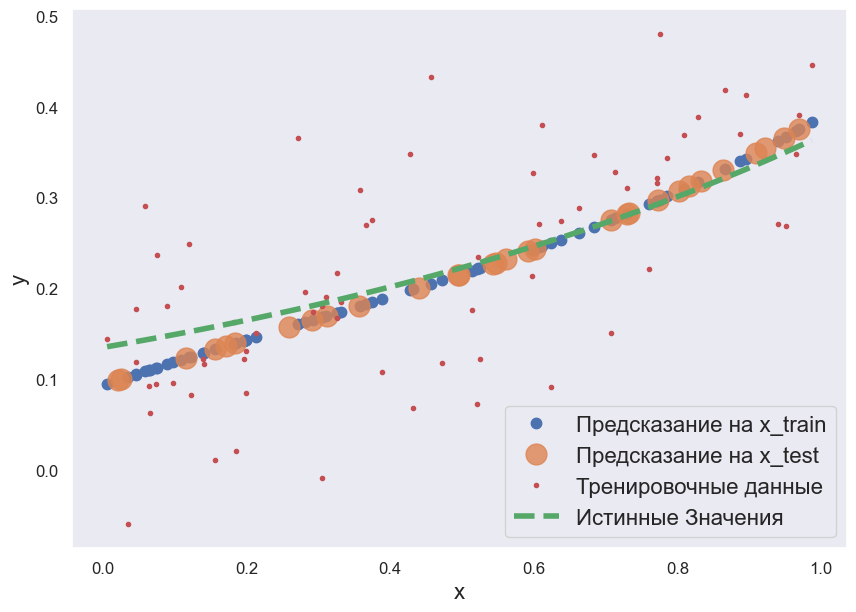

In [1041]:
ridge_regression = RidgeRegression(
    learning_rate=0.25,
    epochs=300,
    batch_size=10,
    l2_penalty=0.001
)

x4_ridge = to_polynom(x4, order=3)
x4_ridge_train, y4_ridge_train, x4_ridge_test, y4_ridge_test = train_test_split(x4_ridge, y4, test_size=0.3)

ridge_regression.fit(x4_ridge_train, y4_ridge_train)

fig = plt.figure(figsize=(10, 7))
plot_model_class(x4_ridge_train, y4_ridge_train, x4_ridge_test, x4_ridge, y4_true, ridge_regression)

### L1 регуляризация

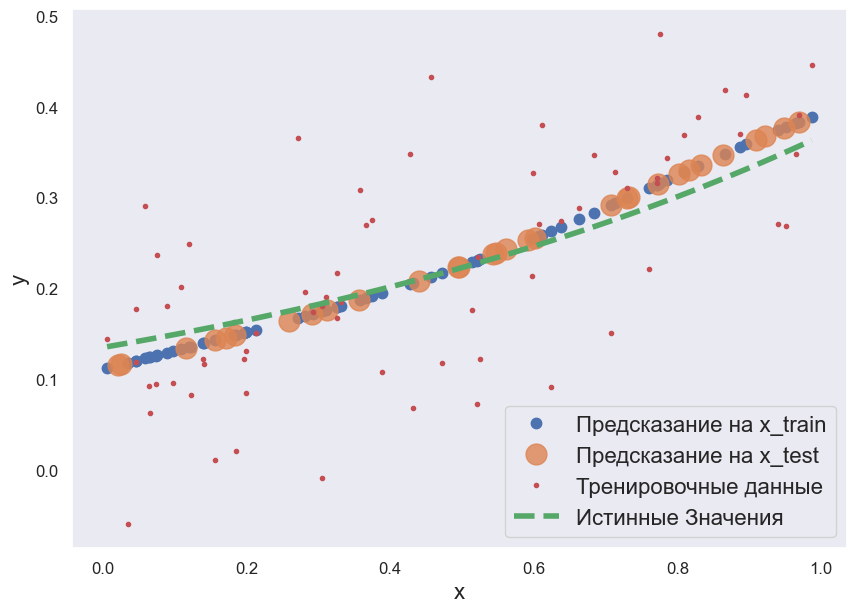

In [1042]:
lasso_regression = LassoRegression(
    learning_rate=0.1,
    epochs=300,
    batch_size=10,
    l1_penalty = 0.001
)

lasso_regression.fit(x4_pol_train, y4_pol_train)

fig  = plt.figure(figsize=(10, 7))
plot_model_class(x4_pol_train, y4_pol_train, x4_pol_test, x4_pol, y4_true, lasso_regression)

# Набора данных Cars Moldova

### Загрузка данных

In [1043]:
car_df = pd.read_csv('data/cars_moldova_data.csv', delimiter=',')

In [1047]:
car_df.sample(5)

,Make,Model,Year,Style,Distance,Engine_capacity,Fuel_type,Transmission,Price,Age,Km_year,Km_year_quantile,Make_model,Make_model_mean_price,Make_model_median_price
5903,Volkswagen,Passat,2006,Universal,210000.0,2000.0,Diesel,Automatic,2000.0,16,13125.000000,Средний пробег,Volkswagen Passat,6767.408497,5700.0
17936,BMW,7 Series,2003,Sedan,250000.0,3500.0,Metan/Propan,Automatic,5300.0,19,13157.894737,Средний пробег,BMW 7 Series,17113.692015,10000.0
14886,Vaz,21099,2019,Sedan,98000.0,1500.0,Petrol,Manual,500.0,3,32666.666667,Большой пробег,Vaz 21099,5755.103448,1250.0
27760,Land Rover,Freelander,2004,SUV,180000.0,1800.0,Metan/Propan,Manual,3950.0,18,10000.000000,Небольшой пробег,Land Rover Freelander,8043.054795,8350.0
31920,Volkswagen,Golf,2012,Hatchback,130000.0,1400.0,Petrol,Automatic,8000.0,10,13000.000000,Средний пробег,Volkswagen Golf,5799.978208,4999.0


### Выделим числовые и категориальные столбцы

In [1045]:
def split_column_by_types(df):
    category_columns = []
    number_columns = []

    for column in df.columns:
        if df[column].dtypes == object or df[column].dtypes == 'category':
            category_columns += [column]
        else:
            number_columns += [column]
    
    return category_columns, number_columns

In [1052]:
category_columns, number_columns = split_column_by_types(car_df)

print(category_columns)
print(number_columns)

['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Km_year_quantile', 'Make_model']
['Year', 'Distance', 'Engine_capacity', 'Price', 'Age', 'Km_year', 'Make_model_mean_price', 'Make_model_median_price']


In [1056]:
car_df_number = car_df[number_columns].copy()

### Выдели в отдельный набор данных числовые признаки

In [1057]:
car_df_number.head(5)

,Year,Distance,Engine_capacity,Price,Age,Km_year,Make_model_mean_price,Make_model_median_price
0,2011,195000.0,1800.0,7750.0,11,17727.272727,8276.508621,7900.0
1,2014,135000.0,1500.0,8550.0,8,16875.000000,7177.654912,6999.0
2,2012,110000.0,1500.0,6550.0,10,11000.000000,4598.121951,5099.0
3,2006,200000.0,1600.0,4100.0,16,12500.000000,4488.550877,4300.0
4,2000,300000.0,2200.0,3490.0,22,13636.363636,8236.543333,7500.0


### Выделим целевой признак стоимости автомобиля в отдельный набор данных и удалим из основного набора